# Protein Signaling Dataset Experiment

## Data Loading

In [44]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from cdt.data import load_dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from torchinfo import summary

# === Load Sachs dataset from CDT ===
print("Loading Sachs protein signaling data...")

data_sachs, _ = load_dataset("sachs")
data_sachs.dropna(inplace=True)  # ensure it's clean

protein_names = list(data_sachs.columns)
print(f"Loaded {data_sachs.shape[0]} samples with {len(protein_names)} proteins.")

# === Standardize data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_sachs.values)

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, X_scaled, test_size=0.2, random_state=42
)

Loading Sachs protein signaling data...
Loaded 7466 samples with 11 proteins.


In [45]:
class SachsDataset(Dataset):
    """Dataset class for Sachs protein signaling data"""
    def __init__(self, X, y=None):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32)) if y is not None else self.X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## CausalNet Architecture

In [46]:
class FeatureEncoder(nn.Module):
    def __init__(self, input_dims):
        super().__init__()
        # produce latent of same dimensionality as inputs
        self.linear = nn.Linear(input_dims, input_dims)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.relu(self.linear(x))

class CausalLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # dim == number of features
        self.A = nn.Parameter(torch.randn(dim, dim) * 0.01)
        self.register_buffer('mask', torch.tril(torch.ones(dim, dim), diagonal=-1))
        self.act = nn.Tanh()
    def forward(self, z):
        A_masked = self.A * self.mask
        parent_info = z @ A_masked
        return z + self.act(parent_info)

class Predictor(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim//2)
        self.fc2 = nn.Linear(dim//2, dim)  # Changed to predict all proteins
    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return self.fc2(h)  # No sigmoid since we're predicting continuous values

class CausalNet(nn.Module):
    def __init__(self, input_dims):
        super().__init__()
        # Ensure encoder, causal layer, and predictor all use the original feature dimension
        self.encoder = FeatureEncoder(input_dims)
        self.causal_layer = CausalLayer(dim=input_dims)
        self.predictor = Predictor(dim=input_dims)
    def forward(self, x):
        # x: [batch, input_dims]
        z = self.encoder(x)             # now [batch, input_dims]
        z_causal = self.causal_layer(z)
        pred = self.predictor(z_causal)
        return pred, z_causal

## Model Training

In [ ]:
# Acyclicity constraint from NOTEARS
def acyclicity_loss(A):
    expm = torch.matrix_exp(A * A)
    return torch.trace(expm) - A.size(0)

def structural_regularization(A, mask):
    A_masked = A * mask
    
    # Encourage sparsity
    sparsity_loss = torch.sum(torch.abs(A_masked))
    
    # Encourage small coefficients
    magnitude_loss = torch.sum(A_masked ** 2)
    
    # Penalize complex structures
    complexity_loss = torch.sum(torch.abs(A_masked) > 0.1)
    
    return sparsity_loss + 0.1 * magnitude_loss + 0.01 * complexity_loss

In [48]:
def train_model(model, train_loader, val_loader, protein_names, n_epochs=100, learning_rate=1e-3):
    """Train the causal neural network"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.MSELoss()  # Changed to MSE for continuous protein values
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Your original regularization parameters
    l1_lambda = 1e-3
    acyclic_lambda = 1.0
    
    train_losses, train_mse = [], []
    
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        total_mse = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred, _ = model(X_batch)
            
            # Your original loss formulation
            mse = criterion(pred, y_batch)
            l1 = torch.norm(model.causal_layer.A, 1)
            acyc = acyclicity_loss(model.causal_layer.A * model.causal_layer.mask)
            struct_reg = structural_regularization(model.causal_layer.A, model.causal_layer.mask)
            loss = mse + l1_lambda * l1 + acyclic_lambda * acyc + struct_reg
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * X_batch.size(0)
            total_mse += mse.item() * X_batch.size(0)
        
        avg_loss = total_loss / len(train_loader.dataset)
        avg_mse = total_mse / len(train_loader.dataset)
        
        train_losses.append(avg_loss)
        train_mse.append(avg_mse)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} — Loss: {avg_loss:.4f} — MSE: {avg_mse:.4f}")
    
    return train_losses, train_mse

## Causal Graph Visualization

In [49]:
def analyze_causal_structure(model, protein_names, threshold_percentile=75):
    """Analyze the learned causal structure"""
    # Your original analysis code
    A_learned = (model.causal_layer.A * model.causal_layer.mask).detach().cpu().numpy()
    
    # Compute absolute weight distribution and choose a data-driven threshold
    weights = np.abs(A_learned.flatten())
    thresh = np.percentile(weights, threshold_percentile)
    print(f"Dynamic threshold ({threshold_percentile}th percentile): {thresh:.4f}")
    
    # Build directed graph over original features
    G = nx.DiGraph()
    for i, src in enumerate(protein_names):
        for j, dst in enumerate(protein_names):
            if abs(A_learned[i, j]) > thresh:
                G.add_edge(src, dst, weight=A_learned[i, j])
    
    print(f"\nLearned causal relationships:")
    for src, dst, data in G.edges(data=True):
        print(f"  {src} -> {dst}: {data['weight']}")
    
    # Visualize
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue',
            font_size=10, font_weight='bold', arrows=True, arrowsize=20,
            edge_color='gray', width=2)
    
    # Add edge labels
    edge_labels = {(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title("Learned Causal Graph - Sachs Protein Signaling Network")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return G, A_learned


In [50]:
def counterfactual_analysis(model, X_test, protein_names, feature_idx, delta):
    """Your original counterfactual analysis"""
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Take a sample for analysis
    x_instance = X_test[0]
    x = torch.tensor(x_instance, dtype=torch.float32).unsqueeze(0).to(device)
    
    # Baseline prediction
    y0, _ = model(x)
    
    # Encode features to latent z
    z = model.encoder(x)
    # Apply intervention: adjust specified latent dimension
    z_cf = z.clone()
    z_cf[0, feature_idx] += delta
    # Propagate through causal layer and predictor
    z_cf = model.causal_layer(z_cf)
    y_cf = model.predictor(z_cf)
    
    baseline = y0.detach().cpu().numpy()[0]
    after = y_cf.detach().cpu().numpy()[0]
    
    print(f"\nCounterfactual Analysis:")
    print(f"Intervention: {protein_names[feature_idx]} += {delta}")
    print(f"Effects on all proteins:")
    for i, protein in enumerate(protein_names):
        print(f"  {protein}: {baseline[i]} -> {after[i]} (Δ: {after[i]-baseline[i]})")
    
    return baseline, after


Model Summary:

Training model...
Epoch 1/100 — Loss: 1.0864 — MSE: 1.0351
Epoch 11/100 — Loss: 0.2803 — MSE: 0.2743
Epoch 21/100 — Loss: 0.2199 — MSE: 0.2139
Epoch 31/100 — Loss: 0.2074 — MSE: 0.2018
Epoch 41/100 — Loss: 0.2031 — MSE: 0.1979
Epoch 51/100 — Loss: 0.2020 — MSE: 0.1965
Epoch 61/100 — Loss: 0.2017 — MSE: 0.1959
Epoch 71/100 — Loss: 0.2004 — MSE: 0.1950
Epoch 81/100 — Loss: 0.2005 — MSE: 0.1949
Epoch 91/100 — Loss: 0.2002 — MSE: 0.1944


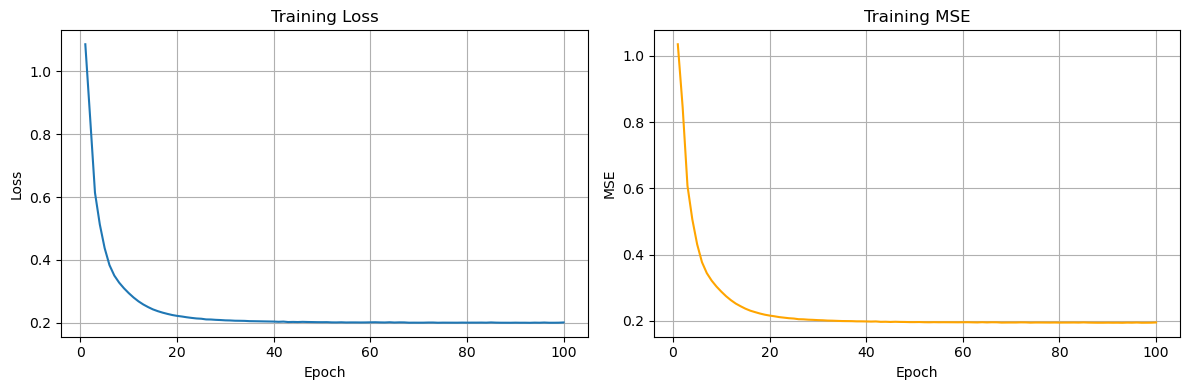


Analyzing learned causal structure...
Dynamic threshold (85th percentile): 0.0001

Learned causal relationships:
  plcg -> praf: 0.0001456307654734701
  plcg -> pmek: -0.00013083365047350526
  PIP3 -> praf: 0.00029324821662157774
  PIP3 -> PIP2: 0.00019799271831288934
  p44/42 -> pmek: -0.00020121809211559594
  p44/42 -> plcg: 0.000110017710539978
  p44/42 -> PIP2: 0.00015184172661975026
  pakts473 -> praf: 0.00011040458048228174
  pakts473 -> p44/42: 0.00022522895596921444
  PKA -> pakts473: -0.00019073288422077894
  PKC -> pmek: -0.00017682179168332368
  PKC -> PIP2: -0.00010599716915749013
  PKC -> PKA: -0.00011271348193986341
  P38 -> PIP3: -0.0001675416569923982
  P38 -> PKC: -0.00023614641395397484
  pjnk -> PIP2: -0.00026452215388417244
  pjnk -> PKA: -0.00012408623297233135
  pjnk -> P38: 0.00024935303372330964


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


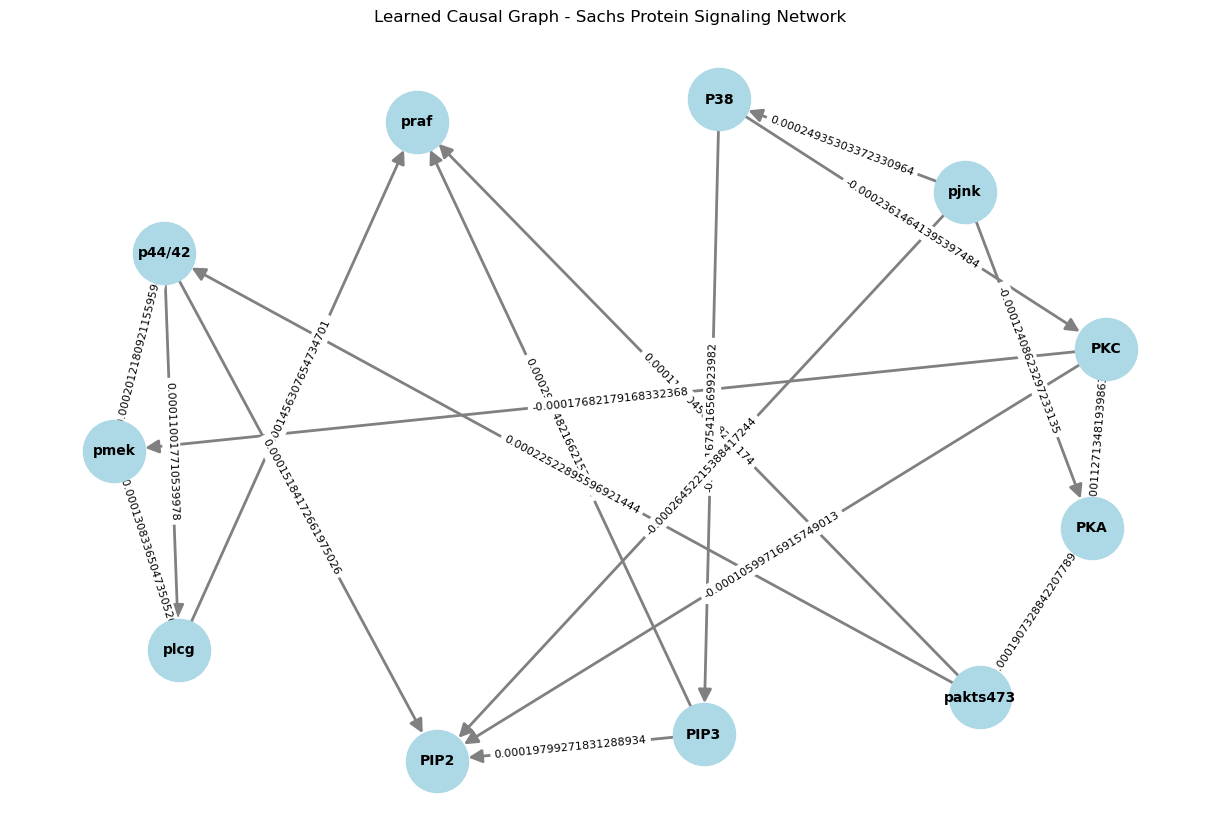


Performing counterfactual analysis...

Counterfactual Analysis:
Intervention: praf += 1.0
Effects on all proteins:
  praf: -0.41788434982299805 -> -0.47674649953842163 (Δ: -0.058862149715423584)
  pmek: -0.4034872055053711 -> -0.45268714427948 (Δ: -0.04919993877410889)
  plcg: 0.5870641469955444 -> 1.1001521348953247 (Δ: 0.5130879878997803)
  PIP2: 0.5923802852630615 -> 1.1258165836334229 (Δ: 0.5334362983703613)
  PIP3: -0.0005055069923400879 -> 0.25627976655960083 (Δ: 0.2567852735519409)
  p44/42: 0.3909837305545807 -> 0.5220563411712646 (Δ: 0.13107261061668396)
  pakts473: 0.4496050477027893 -> 0.6550800204277039 (Δ: 0.20547497272491455)
  PKA: 0.40942853689193726 -> 0.4608522057533264 (Δ: 0.05142366886138916)
  PKC: -0.135908842086792 -> -0.331557035446167 (Δ: -0.195648193359375)
  P38: -0.14451968669891357 -> -0.32249319553375244 (Δ: -0.17797350883483887)
  pjnk: -0.06767630577087402 -> -0.1771399974822998 (Δ: -0.10946369171142578)


In [51]:
train_ds = SachsDataset(X_train, y_train)
test_ds = SachsDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Model ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CausalNet(input_dims=len(protein_names)).to(device)

print(f"\nModel Summary:")
summary(model, input_size=(64, len(protein_names)),
        col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"])

# === Train ===
print(f"\nTraining model...")
train_losses, train_mse = train_model(model, train_loader, test_loader, 
                                      protein_names, n_epochs=100)

# === Plot training curves ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.grid(True)

ax2.plot(range(1, len(train_mse)+1), train_mse, label="Train MSE", color='orange')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MSE")
ax2.set_title("Training MSE")
ax2.grid(True)

plt.tight_layout()
plt.show()

# === Analyze causal structure ===
print(f"\nAnalyzing learned causal structure...")
G, A_learned = analyze_causal_structure(model, protein_names, threshold_percentile=85)

# === Counterfactual analysis ===
print(f"\nPerforming counterfactual analysis...")
# Example: intervene on first protein
baseline, after = counterfactual_analysis(model, X_test, protein_names, 
                                          feature_idx=0, delta=1.0)


Analyzing learned causal structure...
Dynamic threshold (0th percentile): 0.0000

Learned causal relationships:
  pmek -> praf: 9.98583491309546e-05
  plcg -> praf: 0.0001456307654734701
  plcg -> pmek: -0.00013083365047350526
  PIP2 -> praf: 6.023493187967688e-05
  PIP2 -> pmek: -5.096227687317878e-05
  PIP2 -> plcg: 6.213499000295997e-05
  PIP3 -> praf: 0.00029324821662157774
  PIP3 -> pmek: 1.7088386812247336e-06
  PIP3 -> plcg: 9.988227247959003e-05
  PIP3 -> PIP2: 0.00019799271831288934
  p44/42 -> praf: 5.047342710895464e-05
  p44/42 -> pmek: -0.00020121809211559594
  p44/42 -> plcg: 0.000110017710539978
  p44/42 -> PIP2: 0.00015184172661975026
  p44/42 -> PIP3: -6.305987335508689e-05
  pakts473 -> praf: 0.00011040458048228174
  pakts473 -> pmek: 8.319137123180553e-05
  pakts473 -> plcg: -8.836868801154196e-07
  pakts473 -> PIP2: -2.5317640393041074e-06
  pakts473 -> PIP3: -3.348638711031526e-05
  pakts473 -> p44/42: 0.00022522895596921444
  PKA -> praf: 2.2887435989105143e-05
 

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


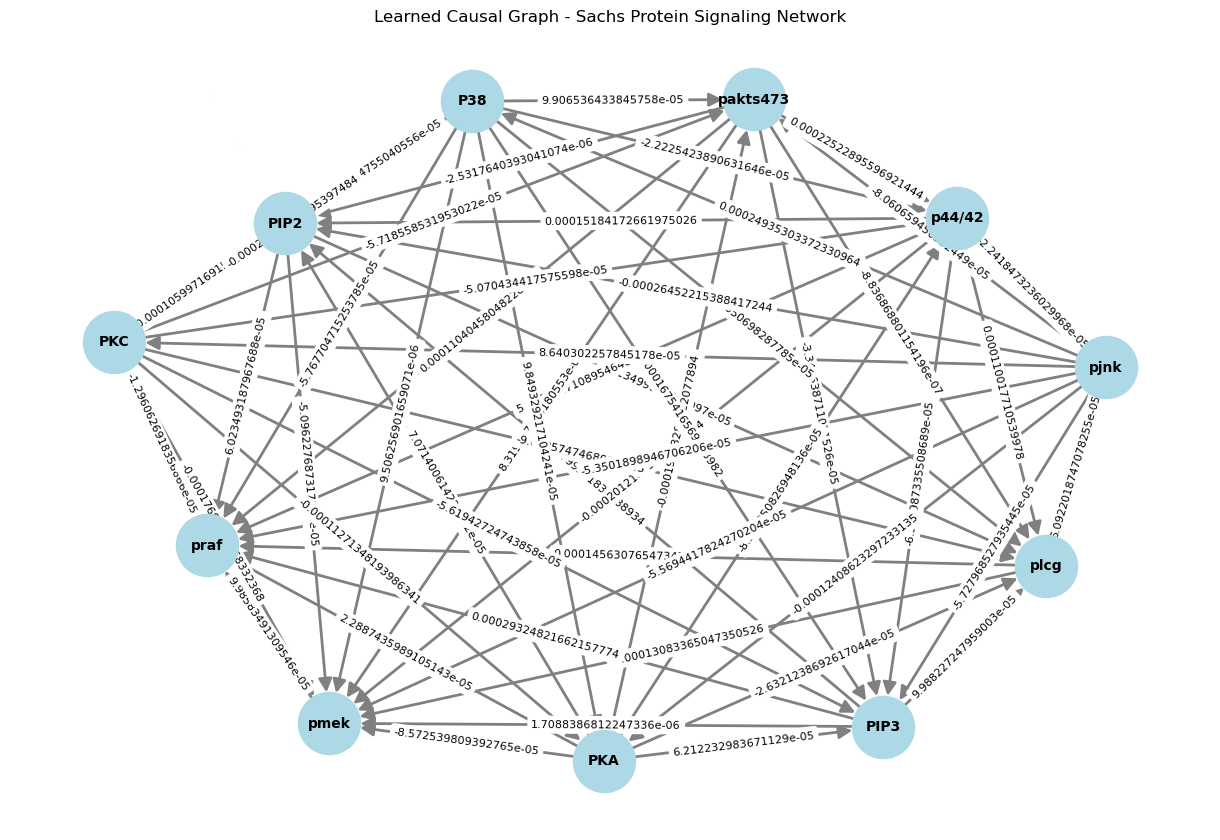

In [52]:
# Analyze learned causal structure
print(f"\nAnalyzing learned causal structure...")
G, A_learned = analyze_causal_structure(model, protein_names, threshold_percentile=0)

In [ ]:
import networkx as nx
from cdt.metrics import SHD
from sklearn.metrics import precision_score, recall_score, f1_score

# Inferred edges with weights
causalnet_edges = {
  ("plcg", "praf"): 0.0001456307654734701,
  ("plcg", "pmek"): -0.00013083365047350526,
  ("PIP3", "praf"): 0.00029324821662157774,
  ("PIP3", "PIP2"): 0.00019799271831288934,
  ("p44/42", "pmek"): -0.00020121809211559594,
  ("p44/42", "plcg"): 0.000110017710539978,
  ("p44/42", "PIP2"): 0.00015184172661975026,
  ("pakts473", "praf"): 0.00011040458048228174,
  ("pakts473", "p44/42"): 0.00022522895596921444,
  ("PKA", "pakts473"): -0.00019073288422077894,
  ("PKC", "pmek"): -0.00017682179168332368,
  ("PKC", "PIP2"): -0.00010599716915749013,
  ("PKC", "PKA"): -0.00011271348193986341,
  ("P38", "PIP3"): -0.0001675416569923982,
  ("P38", "PKC"): -0.00023614641395397484,
  ("pjnk", "PIP2"): -0.00026452215388417244,
  ("pjnk", "PKA"): -0.00012408623297233135,
  ("pjnk", "P38"): 0.00024935303372330964
}

# Sachs consensus network
sachs_edges = {
    ("plcg", "pip2"), ("plcg", "pip3"), ("pip3", "pip2"),
    ("pkc", "raf"), ("pkc", "mek"), ("pkc", "p38"), ("pkc", "jnk"), ("pkc", "pka"),
    ("pka", "raf"), ("pka", "jnk"), ("pka", "p38"), ("pka", "mek"), ("pka", "erk"), ("pka", "akt"),
    ("raf", "mek"), ("mek", "erk"), ("erk", "akt"),
}

# Normalize function
def normalize(name):
  return name.lower().replace("pakts473", "akt").replace("p44/42", "erk").replace("pjnk", "jnk")

# Normalize edges
inferred_set = {(normalize(a), normalize(b)) for a, b in causalnet_edges}
sachs_set = {(normalize(a), normalize(b)) for a, b in sachs_edges}

# Create directed graphs
G_pred = nx.DiGraph()
G_pred.add_edges_from(inferred_set)

G_target = nx.DiGraph()
G_target.add_edges_from(sachs_set)

# Ensure same node set
all_nodes = sorted(set(G_pred.nodes) | set(G_target.nodes))
G_pred.add_nodes_from(all_nodes)
G_target.add_nodes_from(all_nodes)

# Compute SHD using cdt
shd_value = SHD(G_target, G_pred, double_for_anticausal=True)

# Manual metrics
TP = inferred_set & sachs_set
FP = inferred_set - sachs_set
FN = sachs_set - inferred_set

y_true = [1 if edge in sachs_set else 0 for edge in inferred_set | sachs_set]
y_pred = [1 if edge in inferred_set else 0 for edge in inferred_set | sachs_set]

# Results
print("\nResults Summary:")
print(f"Total inferred edges: {len(inferred_set)}")
print(f"Total ground truth edges: {len(sachs_set)}")
print("CDT Structural Hamming Distance (SHD):", shd_value)
print("True Positives (TP):", len(TP), TP)
print("False Positives (FP):", len(FP), FP)
print("False Negatives (FN):", len(FN), FN)


Results Summary:
Total inferred edges: 18
Total ground truth edges: 17
CDT Structural Hamming Distance (SHD): 29
True Positives (TP): 3 {('pkc', 'pka'), ('pip3', 'pip2'), ('pka', 'akt')}
False Positives (FP): 15 {('jnk', 'pip2'), ('erk', 'pmek'), ('akt', 'erk'), ('pip3', 'praf'), ('plcg', 'pmek'), ('jnk', 'p38'), ('plcg', 'praf'), ('akt', 'praf'), ('erk', 'pip2'), ('pkc', 'pmek'), ('p38', 'pip3'), ('pkc', 'pip2'), ('p38', 'pkc'), ('jnk', 'pka'), ('erk', 'plcg')}
False Negatives (FN): 14 {('pka', 'mek'), ('pkc', 'p38'), ('mek', 'erk'), ('pkc', 'raf'), ('pkc', 'mek'), ('raf', 'mek'), ('pka', 'jnk'), ('pka', 'p38'), ('plcg', 'pip3'), ('pkc', 'jnk'), ('plcg', 'pip2'), ('erk', 'akt'), ('pka', 'raf'), ('pka', 'erk')}
Precision: 0.17
Recall: 0.18
F1 Score: 0.17


In [ ]:
import networkx as nx
from cdt.metrics import SHD
from sklearn.metrics import precision_score, recall_score, f1_score



# Inferred edges with weights
causalnet_edges = {
  ("pmek", "praf"): 9.98583491309546e-05,
  ("plcg", "praf"): 0.0001456307654734701,
  ("plcg", "pmek"): -0.00013083365047350526,
  ("PIP2", "praf"): 6.023493187967688e-05,
  ("PIP2", "pmek"): -5.096227687317878e-05,
  ("PIP2", "plcg"): 6.213499000295997e-05,
  ("PIP3", "praf"): 0.00029324821662157774,
  ("PIP3", "pmek"): 1.7088386812247336e-06,
  ("PIP3", "plcg"): 9.988227247959003e-05,
  ("PIP3", "PIP2"): 0.00019799271831288934,
  ("p44/42", "praf"): 5.047342710895464e-05,
  ("p44/42", "pmek"): -0.00020121809211559594,
  ("p44/42", "plcg"): 0.000110017710539978,
  ("p44/42", "PIP2"): 0.00015184172661975026,
  ("p44/42", "PIP3"): -6.305987335508689e-05,
  ("pakts473", "praf"): 0.00011040458048228174,
  ("pakts473", "pmek"): 8.319137123180553e-05,
  ("pakts473", "plcg"): -8.836868801154196e-07,
  ("pakts473", "PIP2"): -2.5317640393041074e-06,
  ("pakts473", "PIP3"): -3.348638711031526e-05,
  ("pakts473", "p44/42"): 0.00022522895596921444,
  ("PKA", "praf"): 2.2887435989105143e-05,
  ("PKA", "pmek"): -8.572539809392765e-05,
  ("PKA", "plcg"): -2.6321238692617044e-05,
  ("PKA", "PIP2"): 7.071400614222512e-05,
  ("PKA", "PIP3"): 6.212232983671129e-05,
  ("PKA", "p44/42"): -8.395050826948136e-05,
  ("PKA", "pakts473"): -0.00019073288422077894,
  ("PKC", "praf"): -1.2960626918356866e-05,
  ("PKC", "pmek"): -0.00017682179168332368,
  ("PKC", "plcg"): -9.6635747468099e-05,
  ("PKC", "PIP2"): -0.00010599716915749013,
  ("PKC", "PIP3"): -5.61942724743858e-05,
  ("PKC", "p44/42"): -5.070434417575598e-05,
  ("PKC", "pakts473"): -5.718558531953022e-05,
  ("PKC", "PKA"): -0.00011271348193986341,
  ("P38", "praf"): -5.767704715253785e-05,
  ("P38", "pmek"): 9.506256901659071e-06,
  ("P38", "plcg"): 7.72050698287785e-05,
  ("P38", "PIP2"): 4.3246174755040556e-05,
  ("P38", "PIP3"): -0.0001675416569923982,
  ("P38", "p44/42"): -2.2225423890631646e-05,
  ("P38", "pakts473"): 9.906536433845758e-05,
  ("P38", "PKA"): 9.849329217104241e-05,
  ("P38", "PKC"): -0.00023614641395397484,
  ("pjnk", "praf"): -5.3501898946706206e-05,
  ("pjnk", "pmek"): -5.5694417824270204e-05,
  ("pjnk", "plcg"): 6.0922018747078255e-05,
  ("pjnk", "PIP2"): -0.00026452215388417244,
  ("pjnk", "PIP3"): -5.727968527935445e-05,
  ("pjnk", "p44/42"): -2.2418473236029968e-05,
  ("pjnk", "pakts473"): -8.060659456532449e-05,
  ("pjnk", "PKA"): -0.00012408623297233135,
  ("pjnk", "PKC"): 8.640302257845178e-05,
  ("pjnk", "P38"): 0.00024935303372330964
}

# Sachs consensus network
sachs_edges = {
    ("plcg", "pip2"), ("plcg", "pip3"), ("pip3", "pip2"),
    ("pkc", "raf"), ("pkc", "mek"), ("pkc", "p38"), ("pkc", "jnk"), ("pkc", "pka"),
    ("pka", "raf"), ("pka", "jnk"), ("pka", "p38"), ("pka", "mek"), ("pka", "erk"), ("pka", "akt"),
    ("raf", "mek"), ("mek", "erk"), ("erk", "akt"),
}

# Normalize function
def normalize(name):
  return name.lower().replace("pakts473", "akt").replace("p44/42", "erk").replace("pjnk", "jnk")

# Normalize edges
inferred_set = {(normalize(a), normalize(b)) for a, b in causalnet_edges}
sachs_set = {(normalize(a), normalize(b)) for a, b in sachs_edges}

# Create directed graphs
G_pred = nx.DiGraph()
G_pred.add_edges_from(inferred_set)

G_target = nx.DiGraph()
G_target.add_edges_from(sachs_set)

# Ensure same node set
all_nodes = sorted(set(G_pred.nodes) | set(G_target.nodes))
G_pred.add_nodes_from(all_nodes)
G_target.add_nodes_from(all_nodes)

# Compute SHD using cdt
shd_value = SHD(G_target, G_pred, double_for_anticausal=True)

# Manual metrics
TP = inferred_set & sachs_set
FP = inferred_set - sachs_set
FN = sachs_set - inferred_set

y_true = [1 if edge in sachs_set else 0 for edge in inferred_set | sachs_set]
y_pred = [1 if edge in inferred_set else 0 for edge in inferred_set | sachs_set]

# Print summary information
print("\nResults Summary:")
print(f"Total inferred edges: {len(inferred_set)}")
print(f"Total ground truth edges: {len(sachs_set)}")
print("CDT Structural Hamming Distance (SHD):", shd_value)
print("True Positives (TP):", len(TP), TP)
print("False Positives (FP):", len(FP), FP)
print("False Negatives (FN):", len(FN), FN)


Results Summary:
Total inferred edges: 55
Total ground truth edges: 17
CDT Structural Hamming Distance (SHD): 64
True Positives (TP): 4 {('pkc', 'pka'), ('pip3', 'pip2'), ('pka', 'akt'), ('pka', 'erk')}
False Positives (FP): 51 {('pmek', 'praf'), ('pip3', 'plcg'), ('erk', 'pip3'), ('pkc', 'erk'), ('erk', 'pmek'), ('pkc', 'pip3'), ('pka', 'pip2'), ('p38', 'praf'), ('pkc', 'pmek'), ('plcg', 'pmek'), ('pip2', 'praf'), ('jnk', 'pka'), ('akt', 'pip2'), ('jnk', 'pip2'), ('jnk', 'pkc'), ('erk', 'praf'), ('p38', 'plcg'), ('pka', 'pip3'), ('p38', 'akt'), ('pip2', 'plcg'), ('akt', 'erk'), ('pka', 'pmek'), ('pkc', 'praf'), ('jnk', 'erk'), ('plcg', 'praf'), ('akt', 'pip3'), ('akt', 'pmek'), ('jnk', 'pip3'), ('erk', 'plcg'), ('jnk', 'pmek'), ('pkc', 'akt'), ('pka', 'praf'), ('pkc', 'plcg'), ('pip3', 'pmek'), ('akt', 'praf'), ('p38', 'pka'), ('p38', 'pkc'), ('jnk', 'praf'), ('pka', 'plcg'), ('p38', 'pip2'), ('p38', 'erk'), ('pip3', 'praf'), ('akt', 'plcg'), ('jnk', 'p38'), ('jnk', 'akt'), ('jnk', '